## The Lorenz chaotic attractor

This example shows the construction of a classic chaotic dynamical system: the Lorenz "butterfly" attractor.  The equations are:
        
$$
\dot{x}_0 = \sigma(x_1 - x_0) \\\
\dot{x}_1 = x_0 (\rho - x_2) - x_1  \\\
\dot{x}_2 = x_0 x_1 - \beta x_2 
$$

Since $x_2$ is centered around approximately $\rho$, and since NEF ensembles are usually optimized to represent values within a certain radius of the origin, we substitute $x_2' = x_2 - \rho$, giving these equations:
$$
\dot{x}_0 = \sigma(x_1 - x_0) \\\
\dot{x}_1 = - x_0 x_2' - x_1\\\
\dot{x}_2' = x_0 x_1 - \beta (x_2' + \rho) - \rho
$$

For more information, see http://compneuro.uwaterloo.ca/publications/eliasmith2005b.html "Chris Eliasmith. A unified approach to building and controlling spiking attractor networks. Neural computation, 7(6):1276-1314, 2005."

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.backends.backend_pdf import PdfPages
%config InlineBackend.figure_format = 'retina'

plt.style.use('seaborn-colorblind')

from matplotlib import rc, rcParams
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica'],'size':7})
rc('text', usetex=True)
rcParams['text.latex.preamble'] = [r'\usepackage{sfmath}']

import nengo
%load_ext nengo.ipynb

<IPython.core.display.Javascript object>

In [2]:
from nengo.utils.ensemble import tuning_curves

model = nengo.Network()
with model:
    num_neurons = np.int_(8*7)
    encoders = np.tile([[1,1,1],
                        [1,1,-1],
                        [1,-1,1],
                        [1,-1,-1],
                        [-1,1,1],
                        [-1,1,-1],
                        [-1,-1,1],
                        [-1,-1,-1]], (np.int_(num_neurons/8),1))
    intercepts = np.linspace(-0.9, 0.9, num_neurons)
    intercepts *= encoders[:,0]
    state = nengo.Ensemble(num_neurons, dimensions=3, intercepts=intercepts, neuron_type=nengo.neurons.Sinusoid(max_overall_rate=1),
                       max_rates=nengo.dists.Uniform(0.8, 1),
                       encoders=encoders, radius=60.)
# with nengo.Simulator(model) as sim:
#     eval_points, activities = tuning_curves(state, sim)
# plt.plot(eval_points, activities, lw=2)
# plt.xlabel("Input signal")
# plt.ylabel("Firing rate (Hz)")

tau = 0.12
sigma = 10
beta = 8.0/3
rho = 28

def feedback(x):
    dx0 = -sigma * x[0] + sigma * x[1]
    dx1 = -x[0] * x[2] - x[1]
    dx2 = x[0] * x[1] - beta * (x[2] + rho) - rho
    
    return [dx0 * tau + x[0], 
            dx1 * tau + x[1], 
            dx2 * tau + x[2]]

with model:
    #state = nengo.Ensemble(2000, 3, radius=60)
    #state = nengo.Ensemble(100, 3, radius=60, neuron_type=nengo.neurons.Sinusoid(max_overall_rate=400))
    #state = nengo.Ensemble(100, 3, radius=60, neuron_type=nengo.neurons.RectifiedLinear())
    nengo.Connection(state, state, function=feedback, synapse=tau)
    state_probe = nengo.Probe(state, synapse=tau)

with nengo.Simulator(model) as sim:
    sim.run(2/tau)

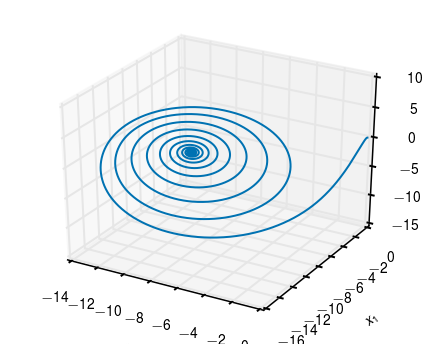

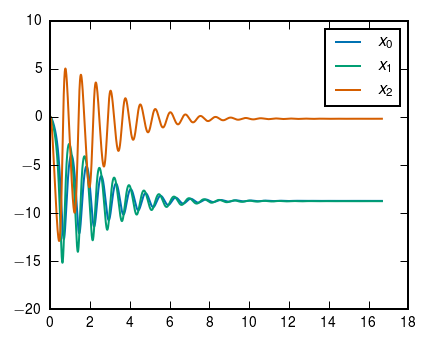

In [3]:
from mpl_toolkits.mplot3d import Axes3D

pp = PdfPages('lorenz_system_3d.pdf')
fig = plt.figure(0, figsize=(3,2.4), dpi=72)
ax = fig.add_subplot(111, projection='3d')
ax.plot(sim.data[state_probe][:, 0],
        sim.data[state_probe][:, 1],
        sim.data[state_probe][:, 2])
ax.set_xlabel('$x_0$')
ax.set_ylabel('$x_1$')
ax.set_zlabel('$x_2$')
plt.tight_layout()
pp.savefig()
pp.close()

pp = PdfPages('lorenz_time_traces.pdf')
fig = plt.figure(1, figsize=(3,2.4), dpi=72)
for variable, label in zip(sim.data[state_probe].T, ['$x_0$', '$x_1$', '$x_2$']):
    plt.plot(sim.trange(), variable, label=label)
plt.legend()
plt.tight_layout()
pp.savefig()
pp.close()


[ 0.88880675  0.99879637  0.98255778  0.97770566  0.8486897   0.85906229
  0.99968138  0.83521474  0.83245367  0.8586848   0.96647906  0.93859973
  0.93358927  0.95951238]


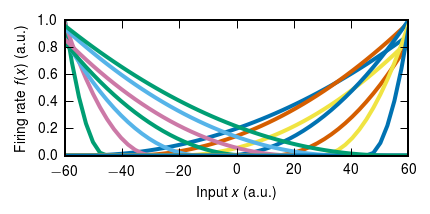

In [4]:
#1D enconders

model = nengo.Network()
with model:
    num_neurons = np.int_(2*7)
    encoders = np.tile([[1],
                        [-1]], (np.int_(num_neurons/2),1))
    intercepts = np.linspace(-0.9, 0.9, num_neurons)
    intercepts *= encoders[:,0]
    state = nengo.Ensemble(num_neurons, dimensions=1, intercepts=intercepts, neuron_type=nengo.neurons.FourierSinusoid(max_overall_rate=1),
                       max_rates=nengo.dists.Uniform(0.8, 1),
                       encoders=encoders, radius=60.)
    
with nengo.Simulator(model) as sim:
    eval_points, activities = tuning_curves(state, sim)
    
with PdfPages('tuning_curves.pdf') as pp:
    fig = plt.figure(2, figsize=(3,1.5), dpi=72)
    plt.plot(eval_points, activities, lw=2)
    plt.xlabel("Input $x$ (a.u.)")
    plt.ylabel("Firing rate $f(x)$ (a.u.)")
    plt.tight_layout()
    pp.savefig()